In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 19 July 2024

# using mask of longitudinal-bins created by 
# - WAOM10extend_shflim_S_0.25Q_OHB_shelf_budget_closure.ipynb
# to integrated over regions.
# Using mask for cont. shelf, land and ice shelf cavities, we
# can separate the heat tendency in each region due to individual
# processes (e.g. advection, diffusion, sfc fluxes)

## loading saved netcdf with each component of RHS heat budget eqn., 
# integrated horizontally & vertically.
# 
#waom_notebook/OHB_shelf/OHB_closure/WAOM10_OHB_[hadv/vadv/hdiff/viff]_regional_using_lon_masks[].py_iceshelf
# _iceshelf refers to only int. within ice shelf cavities of each subsector


In [2]:
# read nc output from WAOM 10km run

import xarray as xr
# import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw
import cmocean

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')

In [3]:
client = Client(threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
print(client)

<Client: 'tcp://127.0.0.1:35435' processes=28 threads=28>


In [4]:
fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/OHB_shelf/'

In [5]:
  %%time
    
    # using xr.open_mfdataset
    
    vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]
    
    ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"

    m = ds.variables["m"]
    time_avg = ds.variables["ocean_time"] 
    ice_draft = ds.variables["zice"]
    
    mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
    mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
    
    print("Vtransform=2")
    #  New formulation (Vtransform(ng) = 2):
    #
    #         z_w(x,y,s,t) = zeta(x,y,t) + [zeta(x,y,t)+ h(x,y)] * Zo_w
    #                 Zo_w = [hc * s(k) + C(k) * h(x,y)] / [hc + h(x,y)]
    hwater = ds.h- abs(ds.zice) # replace ds.h for hwater below
    Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * hwater) / (ds.hc + hwater)
    z_rho = ds.zeta + (ds.zeta + hwater) * Zo_rho 
    
    Zo_w = (ds.hc * ds.s_w + ds.Cs_w * hwater) / (ds.hc + hwater)
    z_w = ds.zeta + (ds.zeta + hwater) * Zo_w 
    
    dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")
    
    lat_rho = dg.variables["lat_rho"]
    lon_rho = dg.variables["lon_rho"]
    lat_u = dg.variables["lat_u"]
    lon_u = dg.variables["lon_u"]
    lat_v = dg.variables["lat_v"]
    lon_v = dg.variables["lon_v"]
    pm = dg.variables["pm"]
    pn = dg.variables["pn"]
    h = dg.variables["h"]
    zice = dg.variables["zice"]
    
    ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
    ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset
    ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])
    
    ds.close()
    dg.close()
    
    # calculate surface sigma_theta (potential density)
    # sigma_t_sfc = gsw.rho(salt[:,-1,:,:],temp[:,-1,:,:],0) - 1000
    area=np.divide(1,pm*pn)

Vtransform=2
CPU times: user 25.7 s, sys: 5.09 s, total: 30.8 s
Wall time: 58.9 s


In [6]:
    # load horizontal diffusion of heat calculated online:
    	# float temp_hdiff(ocean_time, s_rho, eta_rho, xi_rho) ;
    
    ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_dia_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False)
    temp_hdiff = ds.temp_hdiff
    temp_vdiff = ds.temp_vdiff
    temp_hadv = ds.temp_hadv
    temp_vadv = ds.temp_vadv
    ds.close()

In [7]:
    %%time
    # method 2 to calculate Dz:
    # z_w=z_w.chunks(chunks={'eta_rho': '200MB'}) # couldn't change chunks.
    
    Z_w = z_w.transpose('ocean_time','s_w','eta_rho','xi_rho')
    print(z_w.shape, Z_w.shape)
    dz = np.diff(Z_w,axis=1)

(365, 560, 630, 32) (365, 32, 560, 630)
CPU times: user 1min 8s, sys: 1min 22s, total: 2min 30s
Wall time: 2min 24s


In [8]:
    # convert dz to xarray:
    months=np.arange(0,365)*(1/30.41667)
    # save to netcdf file:
    coordinatesC=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)), eta_rho=(['eta_rho'], np.arange(0,560)), xi_rho=(['xi_rho'], np.arange(0,630)))
    
    dz_xr = xr.DataArray(dz, coords = coordinatesC, dims = ['ocean_time','s_rho','eta_rho','xi_rho'])


In [9]:
# load contour (1500m/calving-front):
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
contour_masked_above = np.load(files_path + 'WAOM10_contour_masked_above_1500m_v3', allow_pickle=True)
contour_masked_above_CF = np.load(files_path + 'WAOM10_contour_masked_above_CF_v3', allow_pickle=True)

In [10]:
mask_shelf = ma.masked_where(contour_masked_above==-1000, np.ones(h.shape))
mask_iceshelf = ma.masked_where(contour_masked_above_CF!=-1000, np.ones(h.shape))
mask_outiceshelf = ma.masked_where(contour_masked_above_CF==-1000, np.ones(h.shape))

mask_land = ma.masked_where(h<=40, np.ones(h.shape))


In [11]:
# define constants:
rho0=1035
Cp=3992.1
# Tf = -1.95 # degC
Tf =  -3.534879684448242

In [12]:
# load masks

dm = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/WAOM10_masked_lonBins.nc')
mask_LonBins = dm.variables['__xarray_dataarray_variable__']
dm.close()


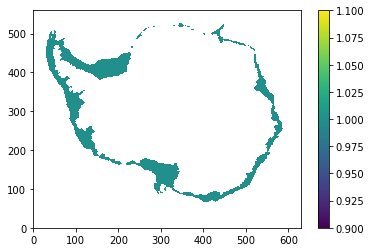

In [13]:
plt.pcolormesh(mask_shelf*mask_iceshelf)
plt.colorbar()

In [14]:
len(mask_LonBins)

120

In [15]:
# Define conditions to mask out (1) off the shelf, (2) land (see plots above)
# PS: condtions used for the OHB closure (ice shelf front contour doesn't matter)
#condition1 = contour_masked_above == -1000
#condition2 = (zice+h) <= 1

# Combine conditions with logical OR
#combined_condition = condition1 | condition2

# here I need the ice shelf mask obtained from the contour:
# define condition:
lonbin = 0
comb_masks = mask_LonBins[lonbin]*mask_shelf*mask_land
condition1 = comb_masks != 1


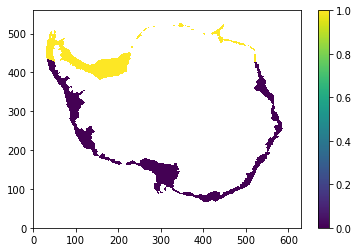

In [16]:
# plt.pcolormesh(mask_LonBins[0:50].sum('time')*mask_shelf) # cont. shelf + ice shelf cavitiess
plt.pcolormesh(mask_LonBins[39:80].sum('time')*mask_shelf*mask_iceshelf) # only cont. shelf
# plt.pcolormesh(comb_masks)
plt.colorbar()


In [17]:
# temp_hadv[0,0,:].shape
tst = ma.masked_where(condition1, temp_hadv[0,0,:])

(50.0, 250.0)

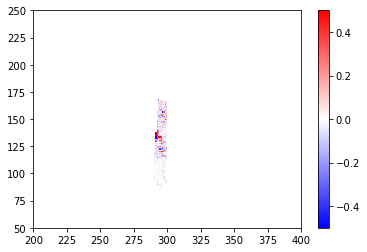

In [18]:
plt.pcolormesh(tst*mask_iceshelf*1e5,vmin=-.5,vmax=.5,cmap='bwr')
plt.colorbar()
plt.xlim(200,400)
plt.ylim(50,250)

### load pre-saved heat budget components

In [19]:
file = files_path + "WAOM10_OHB_lonbins_temp_hadv_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
hadv = ds.variables['__xarray_dataarray_variable__']
ocean_time = ds.ocean_time
lon_bins = ds.lon_bins
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_hdiff_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
hdiff = ds.variables['__xarray_dataarray_variable__']
ocean_time = ds.ocean_time
lon_bins = ds.lon_bins
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_vadv_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
vadv = ds.variables['__xarray_dataarray_variable__']
ocean_time = ds.ocean_time
lon_bins = ds.lon_bins
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_vdiff_vint_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
vdiff = ds.variables['__xarray_dataarray_variable__']
ocean_time = ds.ocean_time
lon_bins = ds.lon_bins
ds.close()

In [20]:
file = files_path + "WAOM10_OHB_lonbins_temp_hadv_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
hadv_is = ds.variables['__xarray_dataarray_variable__']
ocean_time = ds.ocean_time
lon_bins = ds.lon_bins
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_hdiff_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
hdiff_is = ds.variables['__xarray_dataarray_variable__']
ocean_time = ds.ocean_time
lon_bins = ds.lon_bins
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_vadv_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
vadv_is = ds.variables['__xarray_dataarray_variable__']
ocean_time = ds.ocean_time
lon_bins = ds.lon_bins
ds.close()

file = files_path + "WAOM10_OHB_lonbins_temp_vdiff_vint_daily_iceshelf.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
vdiff_is = ds.variables['__xarray_dataarray_variable__']
ocean_time = ds.ocean_time
lon_bins = ds.lon_bins
ds.close()

In [21]:
# load basal melting

file = files_path + "WAOM10_OHB_lonbins_melt_daily.nc"
ds = xr.open_mfdataset(paths=file, chunks={'eta_rho': '200MB'}, parallel=bool)
bmelt = ds.variables['__xarray_dataarray_variable__']
ds.close()

In [22]:
net = hadv + vadv + hdiff +vdiff
net_is = hadv_is + vadv_is + hdiff_is +vdiff_is

#### several simple plots to see what's the data looks like:

Text(0, 0.5, 'time (day)')

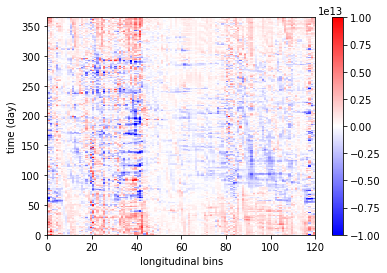

In [23]:
plt.pcolormesh((net-net_is).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
plt.pcolormesh((net).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
plt.colorbar()
plt.xlabel('longitudinal bins')
plt.ylabel('time (day)')

Text(0, 0.5, 'time (day)')

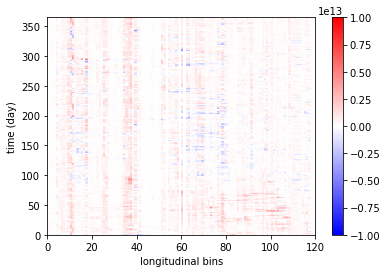

In [24]:
plt.pcolormesh((hadv-hadv_is+hdiff-hdiff_is).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
# plt.pcolormesh((hadv+hdiff).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
plt.colorbar()
plt.xlabel('longitudinal bins')
plt.ylabel('time (day)')

Text(0, 0.5, 'time (day)')

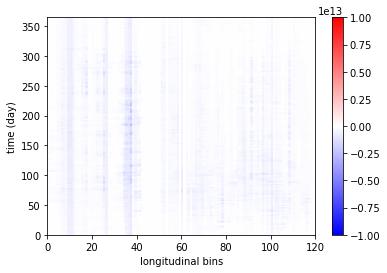

In [25]:
plt.pcolormesh((vadv-vadv_is+vdiff-vdiff_is).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
# plt.pcolormesh((vadv+vdiff).transpose(), vmin=-10e12, vmax=10e12, cmap='bwr')
plt.colorbar()
plt.xlabel('longitudinal bins')
plt.ylabel('time (day)')

Text(0.5, 1.0, 'OHB per sector vol-integ - annual mean \n cont. shelf + ice shelf cav.')

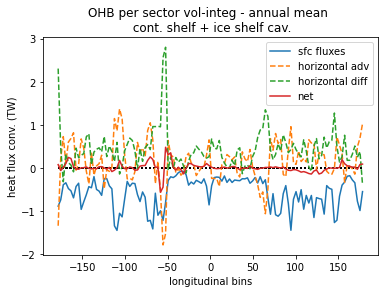

In [26]:
plt.plot(lon_bins,(net)*0,':k')
plt.plot(lon_bins,(vdiff).mean('ocean_time')*1e-12,label='sfc fluxes')
plt.plot(lon_bins,(hadv).mean('ocean_time')*1e-12,'--',label='horizontal adv')
plt.plot(lon_bins,(hdiff).mean('ocean_time')*1e-12,'--',label='horizontal diff')
plt.plot(lon_bins,(net).mean('ocean_time')*1e-12,label='net')
plt.legend()
plt.xlabel('longitudinal bins')
plt.ylabel('heat flux conv. (TW)')
plt.title('OHB per sector vol-integ - annual mean \n cont. shelf + ice shelf cav.')

Text(0.5, 1.0, 'OHB per sector vol-integ - annual mean \n ice shelf cav.')

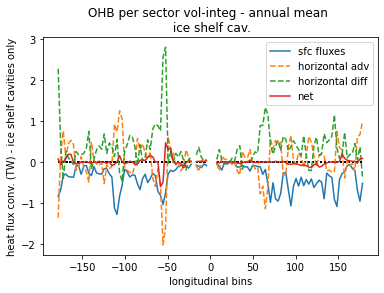

In [27]:
plt.plot(lon_bins,(net_is)*0,':k')
plt.plot(lon_bins,(vdiff_is).mean('ocean_time')*1e-12,label='sfc fluxes')
plt.plot(lon_bins,(hadv_is).mean('ocean_time')*1e-12,'--',label='horizontal adv')
plt.plot(lon_bins,(hdiff_is).mean('ocean_time')*1e-12,'--',label='horizontal diff')
plt.plot(lon_bins,(net_is).mean('ocean_time')*1e-12,label='net')
plt.legend()
plt.xlabel('longitudinal bins')
plt.ylabel('heat flux conv. (TW) - ice shelf cavities only')
plt.title('OHB per sector vol-integ - annual mean \n ice shelf cav.')

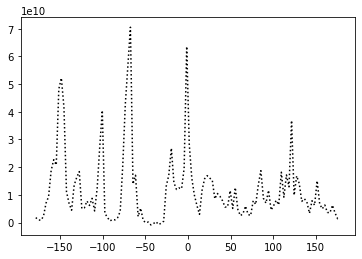

In [32]:
plt.plot(lon_bins,np.nanmean(bmelt, axis=0),'-k')
plt.xlabel('longitude')
plt.ylabel('Basal melting vol-integ \n per long. bin')
plt.title('Basal melting (m3/yr)')

(-2.0, 3.0)

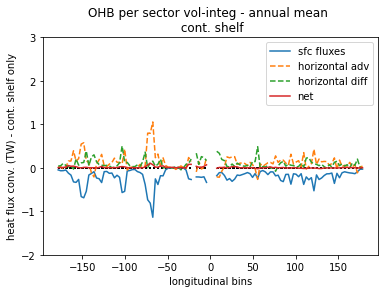

In [28]:
plt.plot(lon_bins,(net-net_is)*0,':k')
plt.plot(lon_bins,(vdiff-vdiff_is).mean('ocean_time')*1e-12,label='sfc fluxes')
plt.plot(lon_bins,(hadv-hadv_is).mean('ocean_time')*1e-12,'--',label='horizontal adv')
plt.plot(lon_bins,(hdiff-hdiff_is).mean('ocean_time')*1e-12,'--',label='horizontal diff')
plt.plot(lon_bins,(net-net_is).mean('ocean_time')*1e-12,label='net')
plt.legend()
plt.xlabel('longitudinal bins')
plt.ylabel('heat flux conv. (TW) - cont. shelf only')
plt.title('OHB per sector vol-integ - annual mean \n cont. shelf')
plt.ylim(-2,3)

Text(0.5, 1.0, 'OHB per sector vol-integ  and cumsummed \n annual mean')

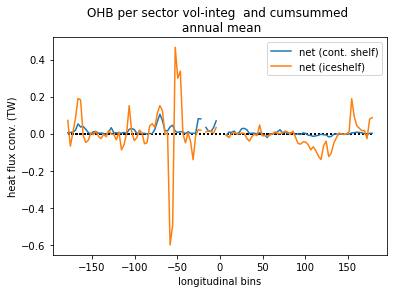

In [29]:
plt.plot(lon_bins,(net)*0,':k')
plt.plot(lon_bins,(net-net_is).mean('ocean_time')*1e-12,label='net (cont. shelf)')
plt.plot(lon_bins,(net_is).mean('ocean_time')*1e-12,label='net (iceshelf)')
plt.legend()
plt.xlabel('longitudinal bins')
plt.ylabel('heat flux conv. (TW)')
plt.title('OHB per sector vol-integ  and cumsummed \n annual mean')

In [ ]:
## cumsum plot with 4 panels:
# 1. cumsum net (cont shelf), annual + seasons
# 2. cumsum RHS (cont shelf), annual + seasons
# 3. cumsum net (ice shelf), annual + seasons
# 4. cumsum RHS (ice shelf), annual + seasons

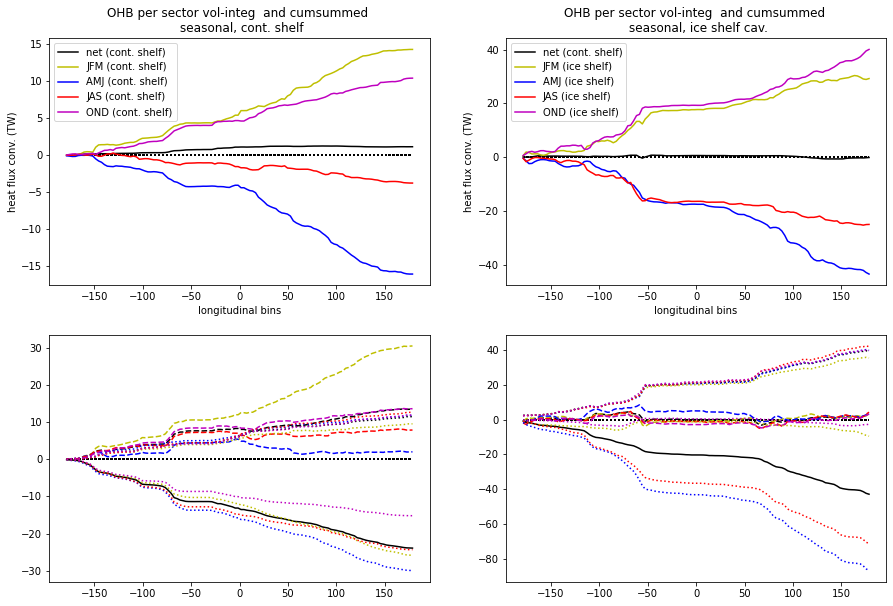

In [153]:
fig = plt.figure(figsize=(15,10))

# Original WAOM10
ax1 = fig.add_subplot(221)# projection=proj)
ax1.plot(lon_bins,(net)*0,':k')
ax1.plot(lon_bins,(net-net_is).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax1.plot(lon_bins,(net-net_is).isel(ocean_time=slice(0,92)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (cont. shelf)')
ax1.plot(lon_bins,(net-net_is).isel(ocean_time=slice(92,184)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (cont. shelf)')
ax1.plot(lon_bins,(net-net_is).isel(ocean_time=slice(184,276)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (cont. shelf)')
ax1.plot(lon_bins,(net-net_is).isel(ocean_time=slice(276,365)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (cont. shelf)')
ax1.legend()
ax1.set_xlabel('longitudinal bins')
ax1.set_ylabel('heat flux conv. (TW)')
ax1.set_title('OHB per sector vol-integ  and cumsummed \n seasonal, cont. shelf')

ax2 = fig.add_subplot(223)# projection=proj)
ax2.plot(lon_bins,(net)*0,':k')
ax2.plot(lon_bins,(hadv-hadv_is).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax2.plot(lon_bins,(hadv-hadv_is).isel(ocean_time=slice(0,92)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax2.plot(lon_bins,(hadv-hadv_is).isel(ocean_time=slice(92,184)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax2.plot(lon_bins,(hadv-hadv_is).isel(ocean_time=slice(184,276)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax2.plot(lon_bins,(hadv-hadv_is).isel(ocean_time=slice(276,365)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax2.plot(lon_bins,(hdiff-hdiff_is).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax2.plot(lon_bins,(hdiff-hdiff_is).isel(ocean_time=slice(0,92)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax2.plot(lon_bins,(hdiff-hdiff_is).isel(ocean_time=slice(92,184)).mean('ocean_time').cumsum()*1e-12,':b',label='hdiff AMJ')
ax2.plot(lon_bins,(hdiff-hdiff_is).isel(ocean_time=slice(184,276)).mean('ocean_time').cumsum()*1e-12,':r',label='hdiff JAS')
ax2.plot(lon_bins,(hdiff-hdiff_is).isel(ocean_time=slice(276,365)).mean('ocean_time').cumsum()*1e-12,':m',label='hdiff OND')
ax2.plot(lon_bins,(vdiff-vdiff_is).mean('ocean_time').cumsum()*1e-12,'-k',label='shflux')
ax2.plot(lon_bins,(vdiff-vdiff_is).isel(ocean_time=slice(0,92)).mean('ocean_time').cumsum()*1e-12,':y',label='shflux JFM')
ax2.plot(lon_bins,(vdiff-vdiff_is).isel(ocean_time=slice(92,184)).mean('ocean_time').cumsum()*1e-12,':b',label='shflux AMJ')
ax2.plot(lon_bins,(vdiff-vdiff_is).isel(ocean_time=slice(184,276)).mean('ocean_time').cumsum()*1e-12,':r',label='shflux JAS')
ax2.plot(lon_bins,(vdiff-vdiff_is).isel(ocean_time=slice(276,365)).mean('ocean_time').cumsum()*1e-12,':m',label='shflux OND')
# ax2.legend()
# ax2.set_title('OHB per sector vol-integ  and cumsummed \n annual + seasonal')

ax3 = fig.add_subplot(222)# projection=proj)
ax3.plot(lon_bins,(net)*0,':k')
ax3.plot(lon_bins,(net_is).mean('ocean_time').cumsum()*1e-12,'-k',label='net (cont. shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(0,92)).mean('ocean_time').cumsum()*1e-12,'y',label='JFM (ice shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(92,184)).mean('ocean_time').cumsum()*1e-12,'b',label='AMJ (ice shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(184,276)).mean('ocean_time').cumsum()*1e-12,'r',label='JAS (ice shelf)')
ax3.plot(lon_bins,(net_is).isel(ocean_time=slice(276,365)).mean('ocean_time').cumsum()*1e-12,'m',label='OND (ice shelf)')
ax3.legend()
ax3.set_xlabel('longitudinal bins')
ax3.set_ylabel('heat flux conv. (TW)')
ax3.set_title('OHB per sector vol-integ  and cumsummed \n seasonal, ice shelf cav.')

ax4 = fig.add_subplot(224)# projection=proj)
ax4.plot(lon_bins,(net)*0,':k')
ax4.plot(lon_bins,(hadv_is).mean('ocean_time').cumsum()*1e-12,'--k',label='hadv')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(0,92)).mean('ocean_time').cumsum()*1e-12,'--y',label='hadv JFM')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(92,184)).mean('ocean_time').cumsum()*1e-12,'--b',label='hadv AMJ')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(184,276)).mean('ocean_time').cumsum()*1e-12,'--r',label='hadv JAS')
ax4.plot(lon_bins,(hadv_is).isel(ocean_time=slice(276,365)).mean('ocean_time').cumsum()*1e-12,'--m',label='hadv OND')
ax4.plot(lon_bins,(hdiff_is).mean('ocean_time').cumsum()*1e-12,':k',label='hdiff')
ax4.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(0,92)).mean('ocean_time').cumsum()*1e-12,':y',label='hdiff JFM')
ax4.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(92,184)).mean('ocean_time').cumsum()*1e-12,':b',label='hdiff AMJ')
ax4.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(184,276)).mean('ocean_time').cumsum()*1e-12,':r',label='hdiff JAS')
ax4.plot(lon_bins,(hdiff_is).isel(ocean_time=slice(276,365)).mean('ocean_time').cumsum()*1e-12,':m',label='hdiff OND')
ax4.plot(lon_bins,(vdiff_is).mean('ocean_time').cumsum()*1e-12,'-k',label='shflux')
ax4.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(0,92)).mean('ocean_time').cumsum()*1e-12,':y',label='shflux JFM')
ax4.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(92,184)).mean('ocean_time').cumsum()*1e-12,':b',label='shflux AMJ')
ax4.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(184,276)).mean('ocean_time').cumsum()*1e-12,':r',label='shflux JAS')
ax4.plot(lon_bins,(vdiff_is).isel(ocean_time=slice(276,365)).mean('ocean_time').cumsum()*1e-12,':m',label='shflux OND')
# ax4.legend()


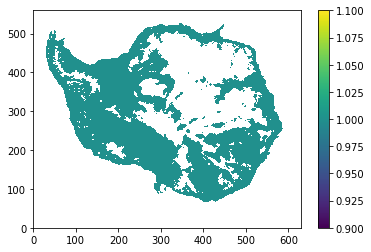

In [176]:
plt.pcolormesh(mask_shelf*mask_land)
plt.colorbar()

In [ ]:
%%time
#### test plotting melt rates:
# plt.pcolormesh(mask_LonBins[39:80].sum('time')*mask_shelf*mask_iceshelf) # only cont. shelf
# print(m.shape, mask_LonBins.shape, mask_shelf.shape)
## (365, 560, 630) (120, 560, 630) (560, 630)

melt_bins = np.empty((365,120))
for ll in np.arange(120):
    comb_masks = mask_LonBins[ll,:]*mask_shelf*mask_land
    condition1 = comb_masks != 1

    for tt in np.arange(365):
        melt_masked =  ma.masked_where(condition1, m.isel(ocean_time=tt))
        melt_area = (melt_masked*area)*86400*365.25 # Convert to m /yr
        melt_area_avg = np.nansum(np.nansum(melt_area,axis=1), axis=0)
        melt_bins[tt,ll] = melt_area_avg
        del melt_masked, melt_area, melt_area_avg


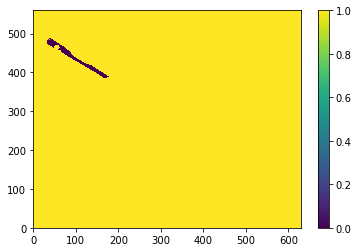

In [171]:
ll=41
comb_masks = mask_LonBins[ll,:]*mask_shelf*mask_land*mask_iceshelf
condition1 = comb_masks != 1
plt.pcolormesh(condition1)
plt.colorbar()

In [ ]:
# saving melt per lon_bins into a netcdf file:
months=np.arange(0,365)*(1/30.41667)
lon_bin_midpts = np.arange(-178.5,180,3)
coordinatesC=dict(ocean_time=months, lon_bins=lon_bin_midpts)
melt_bins_xr = xr.DataArray(melt_bins, coords = coordinatesC, dims = ['ocean_time','lon_bins'])

files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
melt_bins_xr.to_netcdf(files_path + 'WAOM10_OHB_lonbins_melt_daily', mode='w', format="NETCDF4")


#### section to test volume-integrating and save in a netcdf file

In [35]:
files_path + "WAOM10_OHB_lonbins_temp_hadv_vint_daily"

'/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/WAOM10_OHB_lonbins_temp_hadv_vint_daily'

In [62]:
%%time

tlen=365
# heat tendency due to horizontal advection:
temp_hadv_int = np.empty((tlen))
temp_hadv_vol = np.empty(np.squeeze(temp_hadv[:,0,:,:]).shape)
for mm in np.arange(0,tlen):
# - multplying by dz:
    temp_hadv_dz = temp_hadv[mm,:]*dz[mm,:]
    temp_hadv_vint = np.nansum(temp_hadv_dz, axis=0)
    temp_hadv_vint_masked =  ma.masked_where(condition1, temp_hadv_vint)
    temp_hadv_vol[mm,:] = temp_hadv_vint_masked*area
    temp_hadv_int[mm] = np.nansum(np.nansum(temp_hadv_vol[mm,:],axis=1), axis=0)*Cp*rho0


CPU times: user 3min 37s, sys: 2min 34s, total: 6min 12s
Wall time: 9min 53s


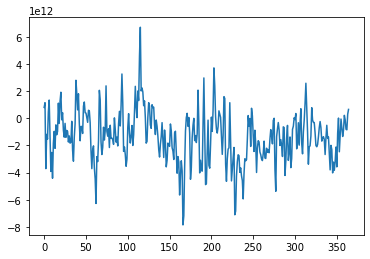

In [66]:
plt.plot(temp_hadv_int)

In [70]:
lon_bin_midpts = np.arange(-178.5,180,3)


In [76]:
temp_hadv_int.shape

(365,)

In [77]:
# saving into a netcdf file:
months=np.arange(0,365)*(1/30.41667)

coordinatesC=dict(ocean_time=months)
temp_hadv_int_xr = xr.DataArray(temp_hadv_int, coords = coordinatesC, dims = ['ocean_time'])

# for py file:
# lon_bin_limits = np.arange(-177,180,3)
# lon_bin_midpts = np.arange(-178.5,180,3)
# coordinatesC=dict(ocean_time=months, lon_bins=lon_bin_midpts)
# temp_hadv_int_xr = xr.DataArray(temp_hadv_int, coords = coordinatesC, dims = ['ocean_time','lon_bins'])

files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
temp_hadv_int_xr.to_netcdf(files_path + 'WAOM10_OHB_1lonbin_temp_hadv_vint_daily', mode='w', format="NETCDF4")


In [69]:
temp_hadv

<xarray.DataArray 'temp_hadv' (ocean_time: 365, s_rho: 31, eta_rho: 560,
                               xi_rho: 630)>
dask.array<concatenate, shape=(365, 31, 560, 630), dtype=float32, chunksize=(5, 31, 280, 630), chunktype=numpy.ndarray>
Coordinates:
  * s_rho       (s_rho) float64 -0.9839 -0.9516 -0.9194 ... -0.04839 -0.01613
    x_rho       (eta_rho, xi_rho) float64 dask.array<chunksize=(560, 630), meta=np.ndarray>
    y_rho       (eta_rho, xi_rho) float64 dask.array<chunksize=(560, 630), meta=np.ndarray>
  * ocean_time  (ocean_time) float64 5.992e+08 5.993e+08 ... 6.306e+08 6.307e+08
Dimensions without coordinates: eta_rho, xi_rho
Attributes:
    long_name:  potential temperature, horizontal advection term
    units:      Celsius second-1
    time:       ocean_time
    field:      temp_hadv, scalar, series

In [68]:
mask_LonBins

<xarray.Variable (time: 120, y: 560, x: 630)>
[42336000 values with dtype=float64]

In [ ]:
## example for vert.+horz. integral:

# %%time
# # 4. heat tendency due to horizontal advection:
# temp_hadv_int = np.empty((tlen))
# temp_hadv_vol = np.empty(np.squeeze(temp_hadv[:,0,:,:]).shape)
# for mm in np.arange(0,tlen):
# # - multplying by dz:
#     temp_hadv_dz = temp_hadv[mm,:]*dz[mm,:]
#     temp_hadv_vint = np.nansum(temp_hadv_dz, axis=0)
#     temp_hadv_vint_masked =  ma.masked_where(combined_condition, temp_hadv_vint)
#     temp_hadv_vol[mm,:] = temp_hadv_vint_masked*area
#     temp_hadv_int[mm] = np.nansum(np.nansum(temp_hadv_vol[mm,:],axis=1), axis=0)*Cp*rho0
